# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Verify if GPU is avalaible

In [2]:
# Verifiy is GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Device: {device}")

Device: cuda


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
from torch.utils.data import random_split

# Define transforms for the training set using data augmentation
train_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Define transforms for the validation and test sets
valid_test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

# Load the original test set
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_test_transform)

# Split the full_testset into testset and validset (50% each)
test_size = valid_size = len(full_testset) // 2
testset, validset = random_split(full_testset, [test_size, valid_size])

# Define test and validation dataloaders
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        #print dimensions of image
        print(images[i].shape)    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

In [5]:
# Explore data

# Define a transform to only convert the images to tensors
view_transform = transforms.Compose([transforms.ToTensor()])

# Create viewing datasets and dataloaders with no normalization
view_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=view_transform)
view_trainloader = torch.utils.data.DataLoader(view_trainset, batch_size=64, shuffle=True)

view_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=view_transform)
view_testloader = torch.utils.data.DataLoader(view_testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def explore_dataset(img_loader):
    dataiter = iter(img_loader)
    
    # Print the total size of the dataset
    print(f'Total number of images: {len(img_loader.dataset)}')
    
    # Initialize a zero array for label counts
    label_counts = np.zeros(10)
    
    # Iterate over all batches and count the labels
    for images, labels in img_loader:
        label_counts += np.bincount(labels.numpy(), minlength=10)
    
    # Print the distribution of labels
    print(f'Label distribution: {label_counts}')
    
    # Plot the distribution of labels
    plt.bar(np.arange(10), label_counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of labels in the dataset')
    plt.show()
    
    # Get the first batch of images and labels
    batch = next(dataiter)
    labels = batch[1]
    images = batch[0]
    
    # Print the dimensions of the images
    print(f'Image dimensions: {images[0].shape}')

Total number of images: 10000
Label distribution: [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


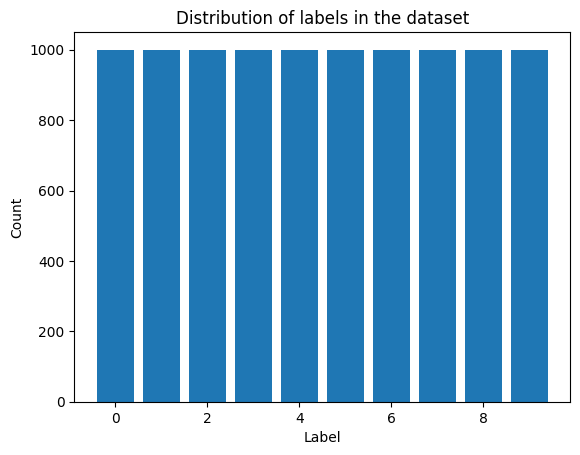

Image dimensions: torch.Size([3, 32, 32])


Total number of images: 50000
Label distribution: [5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]


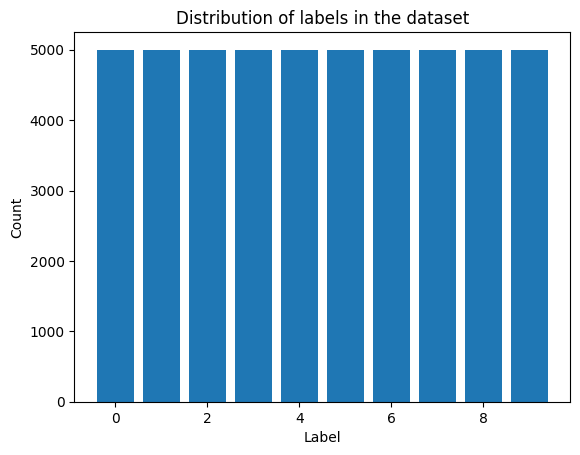

Image dimensions: torch.Size([3, 32, 32])


In [7]:
# Explore viewing datasets
explore_dataset(view_testloader)
print("\n")
explore_dataset(view_trainloader)

View training set
bird
torch.Size([3, 32, 32])


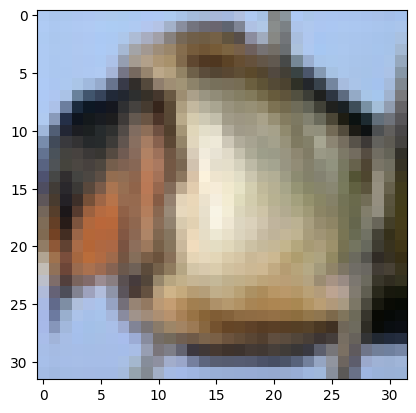

horse
torch.Size([3, 32, 32])


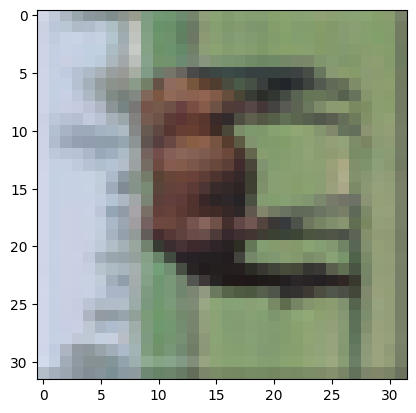

ship
torch.Size([3, 32, 32])


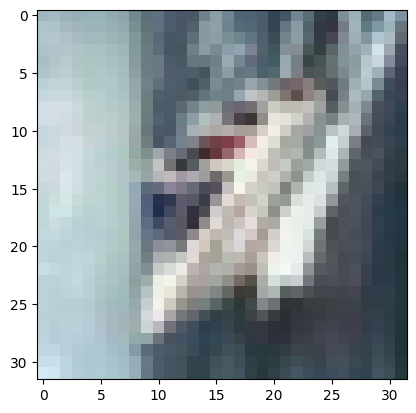

frog
torch.Size([3, 32, 32])


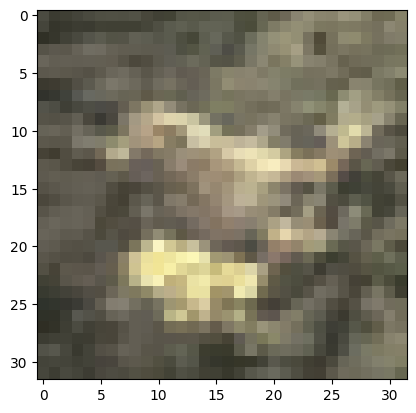

bird
torch.Size([3, 32, 32])


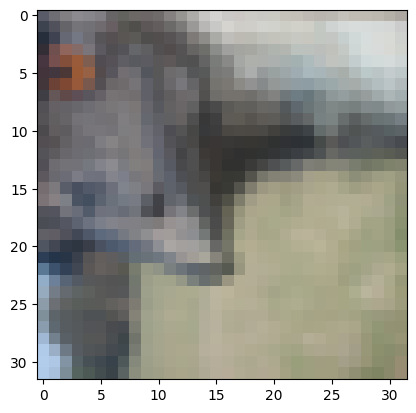

View test set
cat
torch.Size([3, 32, 32])


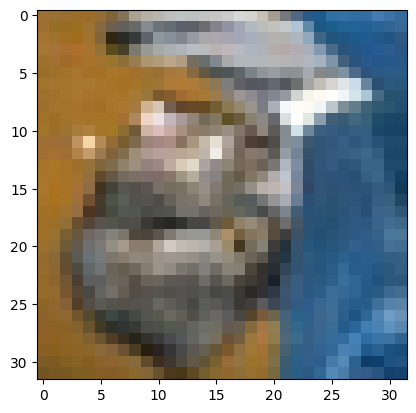

ship
torch.Size([3, 32, 32])


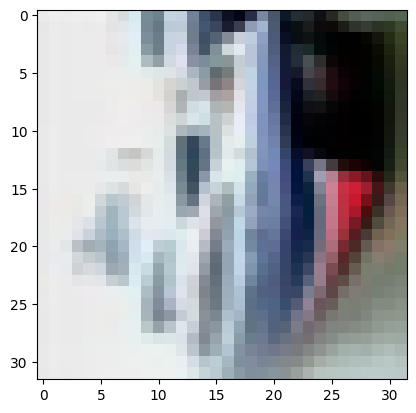

ship
torch.Size([3, 32, 32])


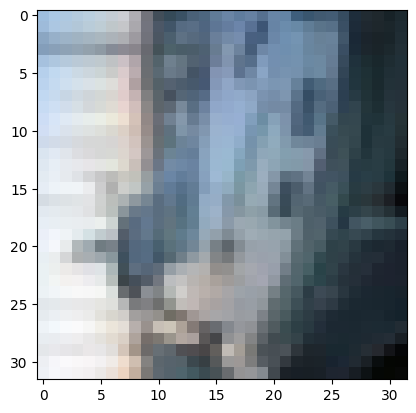

plane
torch.Size([3, 32, 32])


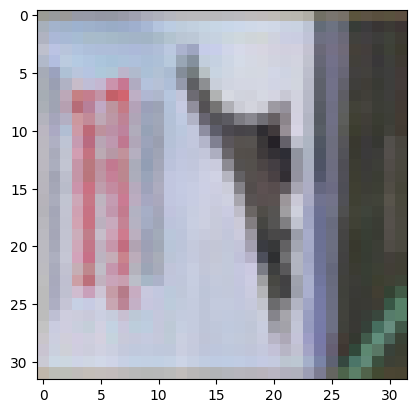

frog
torch.Size([3, 32, 32])


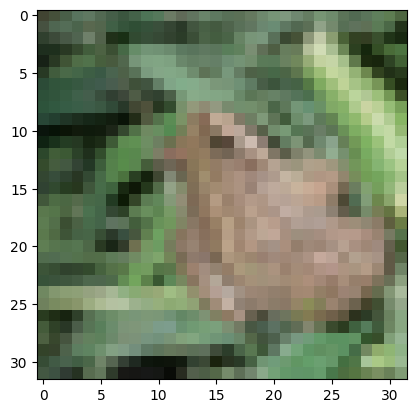

In [8]:
# Use the show5 function to view images from the training and test sets
print("View training set")
show5(view_trainloader)

print("View test set")
show5(view_testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

### Model Architecture:

- **Convolutional Layers:** Three layers to extract spatial features from images, with filters that capture edges, textures, and shapes.

- **Pooling Layers:** Max pooling follows each convolutional layer (except the last) to reduce spatial dimensions and computational load, while achieving spatial invariance.

- **Dropout:** Applied before the fully connected layers to prevent overfitting by randomly dropping out units during training.

- **Fully Connected Layers:** A sequence of layers that further process the extracted features for classification, culminating in a final layer for the 10 CIFAR-10 classes.

- **Activation Functions:** ReLU (Rectified Linear Unit) is used for its efficiency in introducing non-linearity, improving training speed and convergence.

This streamlined model leverages convolutional layers for feature extraction and fully connected layers for classification, incorporating dropout and batch normalization for improved training stability and performance on the CIFAR-10 dataset.

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)  # Adjusted for the output size after conv and pooling layers
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        # Apply conv followed by batch norm, ReLU, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # No dropout before the final layer
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
## Instantiate the model, define the loss and optimization functions
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
# Move model to device cuda
model.to(device)

Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
# Train the model (with early stop)
epochs = 50
steps = 0
patience = 5  # How many epochs to wait after last time validation loss improved.
validation_loss_min = float('inf')  # Initialize the minimum validation loss as infinity
early_stop_counter = 0  # Counter for epochs after last improvement

train_losses, valid_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move input and label tensors to the default device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                # Move input and label tensors to the default device
                images, labels = images.to(device), labels.to(device)

                log_ps = model(images)
                valid_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        valid_losses.append(valid_loss/len(validloader))
        
        # Early Stopping Check
        if valid_loss/len(validloader) < validation_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
                validation_loss_min, valid_loss/len(validloader)))
            validation_loss_min = valid_loss/len(validloader)
            early_stop_counter = 0  # reset counter if validation loss improves
        else:
            early_stop_counter += 1
            print(f'Validation loss did not decrease, early stop counter {early_stop_counter} of {patience}')
            if early_stop_counter >= patience:
                print("Early stopping triggered. Stopping training.")
                break  # Break out of the loop

        # Print only every 5 epochs
        if e % 5 == 0 or e == 0 or e == (epochs - 1):
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Validation Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))

Validation loss decreased (inf --> 1.208009). Saving model ...
Epoch: 1/50..  Training Loss: 1.487..  Validation Loss: 1.208..  Validation Accuracy: 0.573
Validation loss decreased (1.208009 --> 0.980155). Saving model ...
Validation loss decreased (0.980155 --> 0.912373). Saving model ...
Validation loss decreased (0.912373 --> 0.824569). Saving model ...
Validation loss decreased (0.824569 --> 0.795294). Saving model ...
Validation loss decreased (0.795294 --> 0.738960). Saving model ...
Epoch: 6/50..  Training Loss: 0.800..  Validation Loss: 0.739..  Validation Accuracy: 0.738
Validation loss decreased (0.738960 --> 0.699533). Saving model ...
Validation loss decreased (0.699533 --> 0.677903). Saving model ...
Validation loss did not decrease, early stop counter 1 of 5
Validation loss decreased (0.677903 --> 0.676832). Saving model ...
Validation loss decreased (0.676832 --> 0.626442). Saving model ...
Epoch: 11/50..  Training Loss: 0.633..  Validation Loss: 0.626..  Validation Accu

In [13]:
# get the values of the losses from cuda and move them to cpu
valid_losses_cpu = [loss.cpu().item() for loss in valid_losses]
valid_losses_cpu[:5]

[1.208008885383606,
 0.9801551699638367,
 0.912373423576355,
 0.8245694041252136,
 0.7952940464019775]

Plot the training loss (and validation loss/accuracy, if recorded).

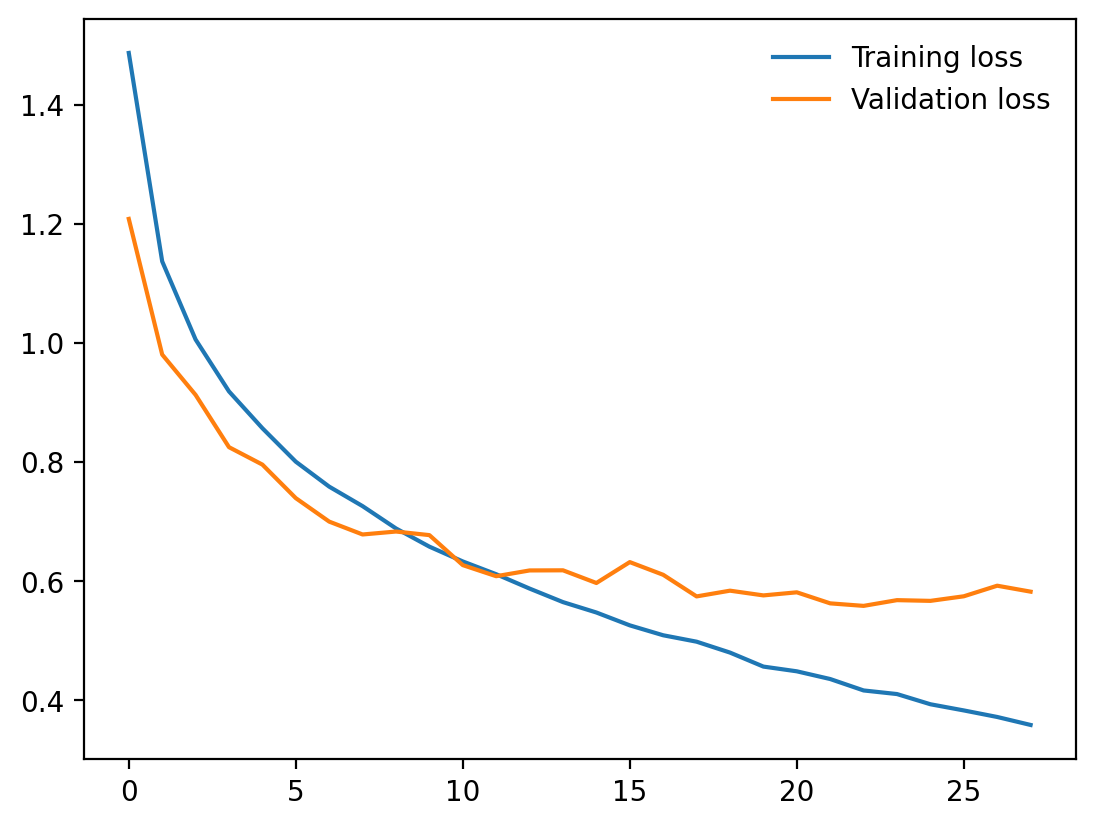

In [14]:
## Plot the training loss and test loss
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses_cpu, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [15]:
# Set model to evaluation mode
model.eval()

# Track number of correct predictions
correct_preds = 0
total_preds = 0

# Don't calculate gradients
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predicted class from the maximum value in the output tensor
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct_preds / total_preds * 100

print(f'Accuracy of the model on test images: {accuracy}%')

Accuracy of the model on test images: 80.76%


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
# Save the model
checkpoint = {
    'input_size': (3, 32, 32),
    'output_size': 10,
    'structure': {
        'conv_layers': [model.conv1.out_channels, model.conv2.out_channels, model.conv3.out_channels],
        'fc_layers': [model.fc1.out_features, model.fc2.out_features, model.fc3.out_features, model.fc4.out_features]
    },
    'state_dict': model.state_dict()
}

torch.save(checkpoint, 'checkpoint.pth')

In [17]:
# Load the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Classifier()
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

model = load_checkpoint('checkpoint.pth')
print(model)

Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
)


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

### Comparison of Accuracy
- **In-house Model:** Achieved an accuracy of 80.76% on the CIFAR-10 dataset.
- **Detectocorp’s Algorithm:** Claims a 70% accuracy rate on the same dataset.
- **State of the Art (GPipe):** Achieves a 99% accuracy rate.



### Considerations for Decision Making

1. **Performance:** The in-house model outperforms Detectocorp's algorithm by 10.76% in terms of accuracy. This demonstrates the internal team's capability to develop a solution that exceeds the performance offered by Detectocorp.

2. **Cost:** Acquiring the algorithm from Detectocorp would likely involve licensing fees, potential recurring costs, and possibly limited customization options. Building in-house offers more control over the model, adaptability to specific needs, and eliminates licensing fees, although it does incur development and maintenance costs.

3. **Scalability and Flexibility:** The in-house model can be further improved and customized for the specific requirements of the self-driving car project. It also offers flexibility regarding data privacy, model adjustments, and integration with other systems.

4. **Future Developments:** Although the in-house model does not achieve the state-of-the-art accuracy of GPipe, it serves as a promising foundation for future improvements. Leveraging advanced techniques, additional data, or more complex architectures could further enhance its performance.

5. **Time and Resources:** If further improvement requires significantly more resources or expertise than is available, purchasing might offer a quicker, though less tailored, solution.

### Recommendation

Based on the current performance advantage of the in-house model over Detectocorp's algorithm, and considering the potential for further improvements, **building the solution in-house is recommended**. This approach not only showcases the team's ability to create competitive models but also offers greater long-term benefits in terms of scalability, flexibility, and cost-effectiveness.

However, it is crucial to balance this with a realistic assessment of the internal team's capacity to maintain and enhance the model. Continuous evaluation against emerging state-of-the-art models and technologies will be essential to ensure that the in-house solution remains competitive and meets the evolving needs of the self-driving car project.